In [74]:
import numpy as np
import matplotlib.pyplot as plt
import sys
np.set_printoptions(threshold=100)

In [38]:
N_inp, N_exc, N_inh = 200, 432, 108
N = sum((N_inp, N_exc, N_inh))
synapses = np.zeros((N,N))
pre = np.concatenate((np.ones((N_inp,1)), 2*np.ones((N_exc,1)), 3*np.ones((N_inh,1))))
post = np.concatenate((np.zeros((N_inp,1)), 2*np.ones((N_exc,1)), 3*np.ones((N_inh,1))))
# plt.figure()
# plt.imshow(img)

In [79]:
# 0=inp, 1=exc, 2=inh
types = np.r_[np.zeros(N_inp, int), np.ones(N_exc, int), np.full(N_inh, 2, int)]

# convenience: boolean selectors for rows (presynaptic) and cols (postsynaptic)
is_inp = (types == 0)
is_exc = (types == 1)
is_inh = (types == 2)
idx_net = np.where(~is_inp)[0]  # indices of E+I neurons

gx, gy, gz = 6, 6, 15
assert gx * gy * gz == (N_exc + N_inh)

# unit grid, centered; set spacing if desired (e.g., micrometers)
grid = np.stack(np.meshgrid(np.arange(gx), np.arange(gy), np.arange(gz), indexing='ij'),
                axis=-1).reshape(-1, 3).astype(float)
grid -= grid.mean(axis=0)              # center at origin
spacing = np.array([1.0, 1.0, 1.0])    # (dx, dy, dz); change if you want physical units
grid *= spacing

# assign positions: first N_exc to E, remaining to I
# pos = np.zeros((N, 3), float)
# pos[is_exc] = grid[:N_exc]
# pos[is_inh] = grid[N_exc:]

# (optional) randomize E/I placement over the grid:
rng = np.random.default_rng(0)
perm = rng.permutation(grid.shape[0])
pos[is_exc] = grid[perm[:N_exc]]
pos[is_inh] = grid[perm[N_exc:]]

# ---- pairwise Euclidean distances ----
P = pos[idx_net]                               # (540, 3)
diff = P[:, None, :] - P[None, :, :]
D_net = np.sqrt(np.sum(diff * diff, axis=2))   # (540, 540)

D = np.zeros((N, N), float)
D[np.ix_(idx_net, idx_net)] = D_net            # inputs rows/cols remain 0
# (autapses distance 0 on the diagonal; you already remove autapses later)

# masks (pre on rows, post on cols)
masks = {
    "E->E": is_exc[:, None] & is_exc[None, :],
    "E->I": is_exc[:, None] & is_inh[None, :],
    "I->E": is_inh[:, None] & is_exc[None, :],
    "I->I": is_inh[:, None] & is_inh[None, :],
    "inp->E": is_inp[:, None] & is_exc[None, :],
}

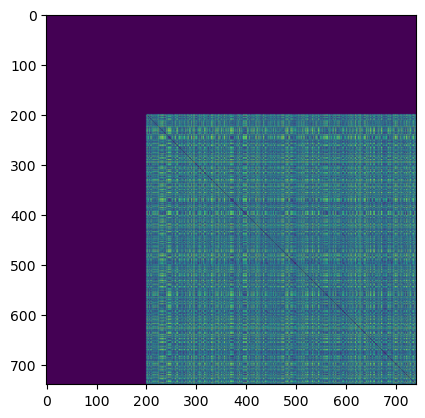

In [80]:
plt.figure()
plt.imshow(D)

In [77]:
D.flatten()[-10:]

array([9., 8., 7., 6., 5., 4., 3., 2., 1., 0.])

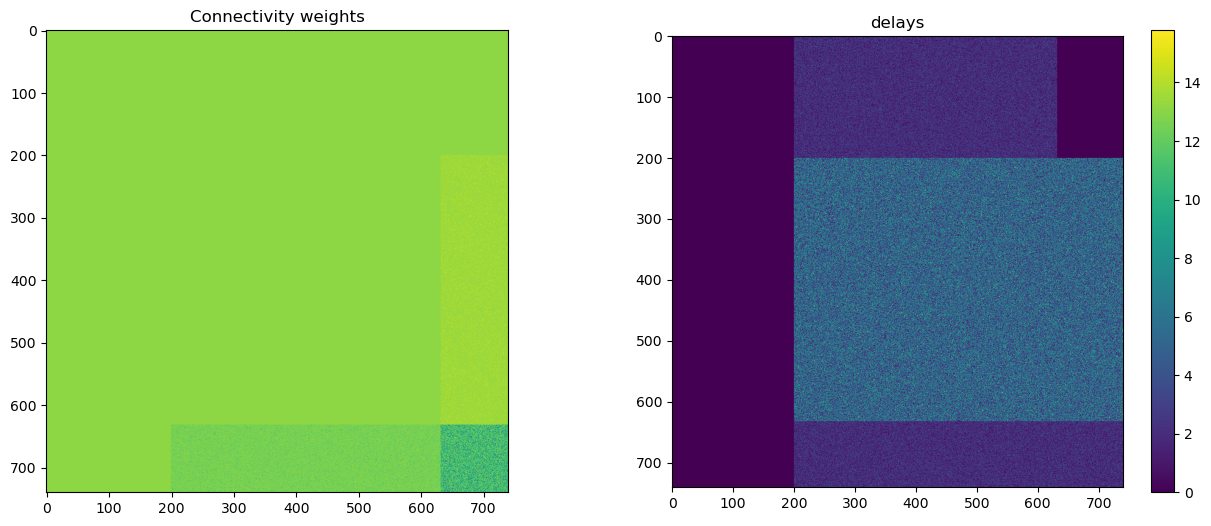

In [59]:
# helper: draw Gamma by mean and CV
def gamma_from_mean_cv(rng, mean, cv, size):
    k = 1.0 / (cv ** 2)           # shape
    theta = mean * (cv ** 2)      # scale
    return rng.gamma(k, theta, size=size)
    
# helper: normal draws by mean and CV, enforcing positivity
def normal_from_mean_cv_pos(rng, mean, cv, size):
    sigma = mean * cv
    x = rng.normal(loc=mean, scale=sigma, size=size)
    # resample any non-positive values to keep delays >= 0
    bad = x <= 0
    while np.any(bad):
        x[bad] = rng.normal(loc=mean, scale=sigma, size=bad.sum())
        bad = x <= 0
    return x
    
rng = np.random.default_rng(42)
W = np.zeros((N, N), dtype=float)
delays = np.zeros((N, N), dtype=float)

# specs: (mean, cv, sign)
weight_specs = {
    "E->E":   (2.5,   0.7,  +1),
    "E->I":   (1000., 0.7,  +1),
    "I->E":   (1375., 0.7,  -1),
    "I->I":   (6000., 0.7,  -1),
    "inp->E": (15.,   0.07, +1),
}

delay_specs = {
    "E->E":   (5.0, 0.5),
    "E->I":   (5.0, 0.5),
    "I->E":   (2.0, 0.5),
    "I->I":   (2.0, 0.5),
    "inp->E": (2.0, 0.5),
}

for key, (mean, cv, sign) in weight_specs.items():
    m = masks[key]
    n = m.sum()
    if n == 0:
        continue
    W[m] = sign * gamma_from_mean_cv(rng, mean, cv, size=n)

for key, (mean, cv) in delay_specs.items():
    m = masks[key]
    n = m.sum()
    if n == 0:
        continue
    delays[m] = normal_from_mean_cv_pos(rng, mean, cv, size=n)

fig,ax = plt.subplots(1,2,figsize=(16,6))
im1 = ax[0].imshow(W)
im1 = ax[1].imshow(delays)
ax[0].set_title("Connectivity weights")
ax[1].set_title("delays")
fig.colorbar(im1)


In [84]:
import numpy as np

# ---- inputs you already have ----
# N, masks = {...}  # masks with keys: "E->E","E->I","I->E","I->I","inp->E"
# rng = np.random.default_rng(42)

# Optional: pairwise distances (NxN). Required for distance-dependent rules.
# D[i,j] is distance from presynaptic i to postsynaptic j (same indexing as W).
# Provide your own D. Example if you have 2D positions 'pos' (N x 2):
# from scipy.spatial.distance import cdist
# D = cdist(pos, pos)   # shape (N,N)

# ---- table encoded here ----
conn_specs = {
    "inp->E": {"p": 0.50, "mode": "uniform"},
    "E->E":   {"p": 0.50, "mode": "uniform"},
    "E->I":   {"p": 0.04, "mode": "distance", "c": 2e5, "lam": 0.25},
    "I->E":   {"p": 0.05, "mode": "distance", "c": 4e5, "lam": 0.25},
    "I->I":   {"p": 0.04, "mode": "distance", "c": 1e5, "lam": 0.25},
}

def sample_connections(rng, masks, D=None, specs=conn_specs, no_autapse=True):
    N = next(iter(masks.values())).shape[0]
    C = np.zeros((N, N), dtype=bool)

    for key, rule in specs.items():
        m = masks[key]
        n = m.sum()
        if n == 0: 
            continue

        p_target = rule["p"]

        if rule["mode"] == "uniform":
            C[m] = rng.random(n) < p_target

        else:
            if D is None:
                raise ValueError(f"Distance matrix D is required for distance-dependent '{key}'")
            # unnormalized kernel: k = c * exp(-lam * d)
            dsub = D[m]
            k = rule["c"] * np.exp(- dsub/rule["lam"])

            # map kernel to probabilities in (0,1) and match the mean to p_target
            # Use a bounded logistic mapping p = 1 - exp(-alpha * k)
            # Find alpha by binary search so mean(p) ≈ p_target
            lo, hi = 0.0, 1e12
            for _ in range(40):
                mid = 0.5 * (lo + hi)
                p_mid = 1.0 - np.exp(-mid * k)
                if p_mid.mean() < p_target:
                    lo = mid
                else:
                    hi = mid
            p_ij = 1.0 - np.exp(-hi * k)

            # draw Bernoulli with heterogeneous p_ij
            C[m] = rng.random(n) < p_ij

    if no_autapse:
        np.fill_diagonal(C, False)

    return C

# ---- build mask ----
C = sample_connections(rng, masks, D=D)  # pass your distance matrix D
# If you only want the uniform parts for now (no D available):
# C = sample_connections(rng, masks, D=np.zeros((N,N)))
plt.figure()
plt.imshow(C)

Text(0.5, 0.98, 'Synapse masks')

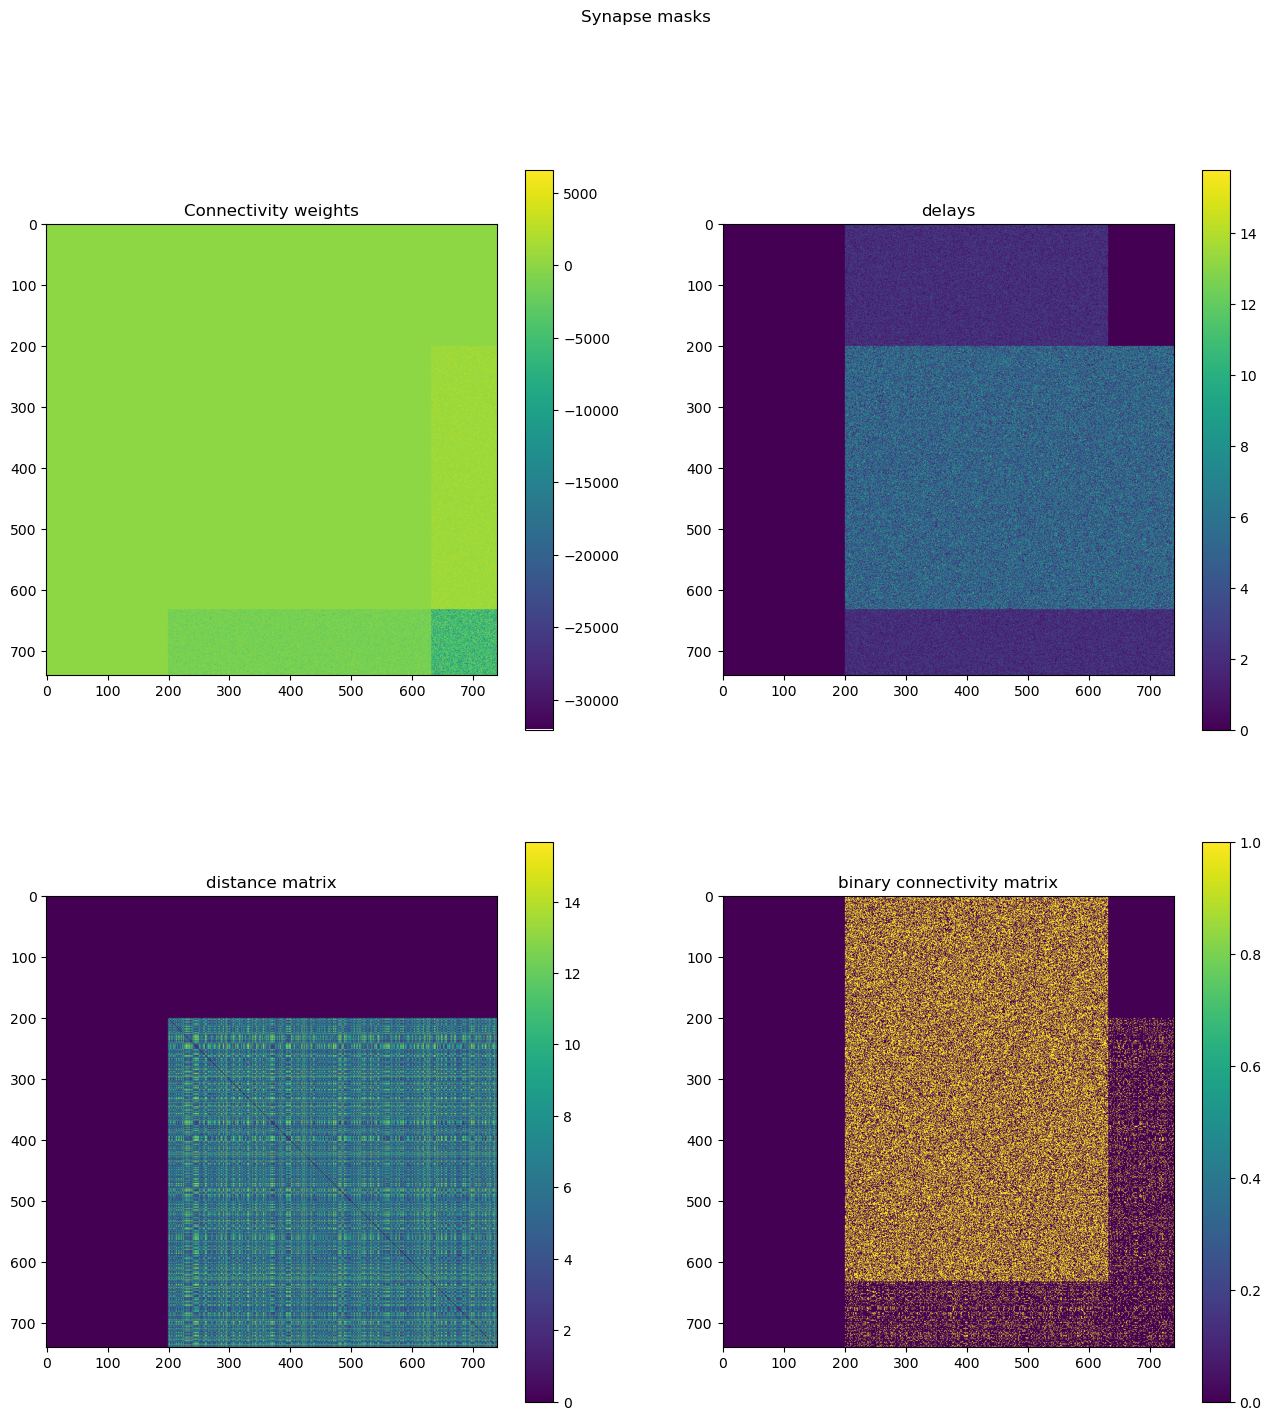

In [95]:

fig,ax = plt.subplots(2,2,figsize=(16,16))
im1 = ax.flatten()[0].imshow(W)
im2 = ax.flatten()[1].imshow(delays)
im3 = ax.flatten()[2].imshow(D)
im4 = ax.flatten()[3].imshow(C)
ax.flatten()[0].set_title("Connectivity weights")
ax.flatten()[1].set_title("delays")
ax.flatten()[2].set_title("distance matrix")
ax.flatten()[3].set_title("binary connectivity matrix")
fig.colorbar(im1)
fig.colorbar(im2)
fig.colorbar(im3)
fig.colorbar(im4)
plt.suptitle('Synapse masks')


In [ ]:

u_n, R_n = np.ones(N) # n-th spike
U,D,F = np.ones((N,N)), np.ones((N,N)), np.ones((N,N)) np.random.normal(loc=5, scale=2, size=(N,N))

In [3]:
u_n = u_n*np.e**(-delta_t/F) + U*(1- u_n*np.e**(-delta_t/F))
R_n = R_n(1*u_n)*np.e**(delta_t/D) + 1 - np.e**(-delta_t/D)


NameError: name 'u_n' is not defined